In [18]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
# Configure visualisations
#%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
sns.set(color_codes=True) # Set style and color of graphs

import pandas as pd
cap = pd.read_csv("/Users/houzhuo/Downloads/capdata3.csv")
robot    = pd.read_csv("/Users/houzhuo/Downloads/robot.csv")
full = pd.concat([cap,robot],axis=1)
print(full.shape,cap.shape,robot.shape)
dataset = pd.concat( [  full['76'],full['77'],full['78'],full['79'],full['80'],full['81'],full['Shoulder_R']] , axis=1 )
dataset.head()

(11420, 108) (11420, 82) (11420, 26)


,76,77,78,79,80,81,Shoulder_R
0,-30.8785,3.41886,31.3622,18.1900,3.72069,-22.2601,2199.000000
1,-30.3154,3.80461,31.6069,17.8124,4.00431,-22.5305,2193.141304
2,-29.9289,4.06432,31.7756,17.5476,4.19606,-22.7126,2187.282609
3,-29.9473,4.08651,31.8139,17.5343,4.22746,-22.7375,2181.423913
4,-30.0450,4.05349,31.7724,17.5933,4.21535,-22.6831,2175.565217


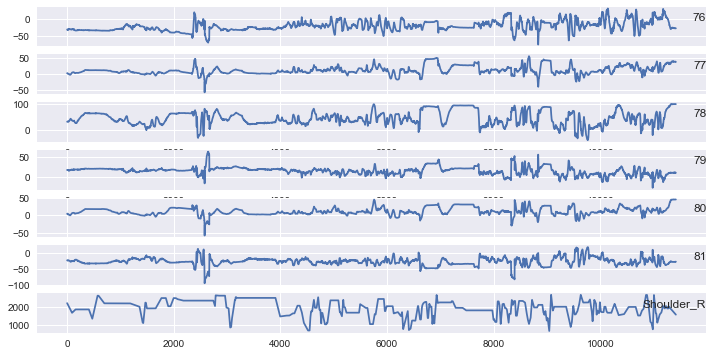

In [19]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3,4,5,6]
i=1
plt.figure(figsize=(12,6))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [13]:
from sklearn.preprocessing import MinMaxScaler
values = dataset.values
#values = dataset.astype(np.float32)
n_features=3
#for i in range(4):
#    scaled[:,i] =values[:,i] - np.mean(values[:,i], axis = 0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


train = scaled[:8000,:]
val = scaled[8000:,:]




n_obs = n_features
train_X,train_y = train[:,:n_obs],train[:,-1]
val_X,val_y = val[:,:n_obs],val[:,-1]#第一个多少行
#test_X,test_y = test[:,:n_obs],test[:,-1]
print(train_X.shape,train_y.shape)

(8000, 3) (8000,)


In [14]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn import model_selection

rf = RandomForestRegressor(n_estimators=190, 
                           max_features= 'sqrt',verbose= 0 )
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
gbm = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
lgb = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [15]:
print('5-fold cross validation:\n')
stack = StackingCVRegressor(regressors=(rf,xgb,ENet, KRR,lgb, gbm), 
                          meta_regressor=ENet)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
stack.fit(train_X, train_y)
#sclf_pred = sclf.predict(X_train.values)
stack_train_pred = stack.predict(train_X)
stack_pred = stack.predict(val_X)
print(rmsle(train_y, stack_train_pred))


5-fold cross validation:

0.01632172555415298


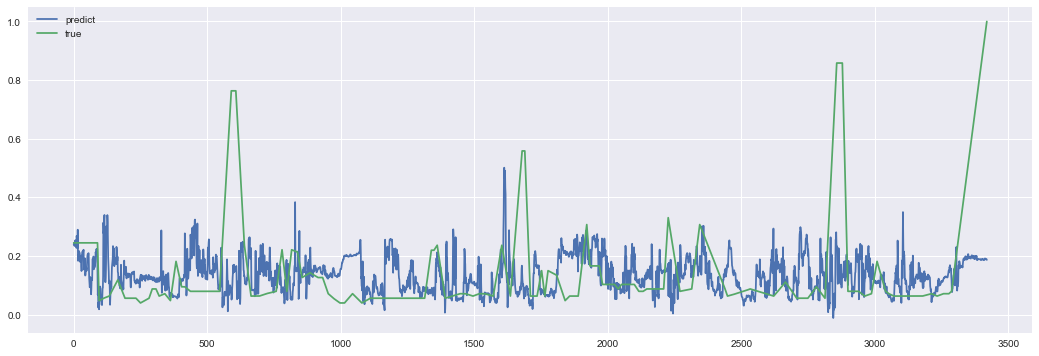

In [16]:
plt.figure(figsize=(18,6))
plt.plot(stack_pred, label = 'predict')
plt.plot(val_y, label = 'true')
plt.legend()
plt.show()

[342.3, 339.7, 440.4, 315.9, 439.3, 401.3, 437.4, 575.5, 407.6, 682.0]